In [1]:
import imp
import os
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import glob
import cv2
import PIL
import matplotlib.pyplot as plt
from pyMLaux.functions import evaluate_classification_result, plot_history

# DALLE variations datasets base base line: Resnet Base
Check for GPU

In [2]:
tf.get_logger().setLevel('ERROR')

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Basic constants

In [6]:
data_dir = "./../data/dalle-variations-resized"
data_dir_test = "./../data/rome-validation"
batch_size = 16
number_images = 50
image_height = 224
image_width = 224
nr_color_channels = 3
seed = 2023

Create ImageDataGenerator for data augmentation of training data

In [7]:
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=(1. / 255),
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   rotation_range=10,
                                   preprocessing_function=keras.applications.resnet50.preprocess_input,
                                   horizontal_flip=True,
                                   fill_mode='constant',
                                   cval=0)

Get training data

In [8]:
img_train = datagen.flow_from_directory(data_dir, target_size=(image_width,image_height), 
                                                    batch_size=batch_size, seed=seed,
                                                    class_mode='categorical')
img_train

Found 1205 images belonging to 5 classes.


Get test data

In [9]:
img_test = datagen.flow_from_directory(data_dir_test, target_size=(image_width,image_height), 
                                                    batch_size=batch_size, seed=seed,
                                                    class_mode='categorical')
img_test

Found 50 images belonging to 5 classes.


Load ResNet50

(approach taken from: https://medium.com/@kenneth.ca95/a-guide-to-transfer-learning-with-keras-using-resnet50-a81a4a28084b)

In [10]:
input_tensor = keras.Input(shape=(image_height,image_width,nr_color_channels))
resnet50_model = keras.applications.ResNet50(include_top=False,weights="imagenet",input_tensor=input_tensor)

In [11]:
for layer in resnet50_model.layers[:134]:
    layer.trainable = False

In [12]:
model = keras.models.Sequential()
model.add(resnet50_model)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(5,activation='softmax'))


Create model checkpoints

In [13]:
filepath = "./" + 'models/dalle_variation_resnet_base/dalle_variation_resnet_base_{epoch:02d}-{val_accuracy:.4f}.hdf5'
check_point = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                                                save_best_only=True, mode='max')

In [14]:
callbacks_list = [check_point]

In [15]:
model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.RMSprop(learning_rate=2e-5),
                  metrics=['accuracy'])

In [16]:
history = model.fit(img_train,
                    steps_per_epoch=((len(img_train.filenames)) // batch_size), 
                    epochs=25,
                    validation_data=img_test, 
                    validation_steps=(len(img_test.filenames) // batch_size),
                    callbacks=callbacks_list)

Epoch 1/25
75/75 [==============================] - 30s 242ms/step - loss: 1.8304 - accuracy: 0.4819 - val_loss: 2.2272 - val_accuracy: 0.2083

Epoch 00001: val_accuracy improved from -inf to 0.20833, saving model to ./models/dalle_variation_resnet_base\dalle_variation_resnet_base_01-0.2083.hdf5


c:\Users\selin\miniconda3\envs\cov-project\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/25
75/75 [==============================] - 13s 169ms/step - loss: 1.1818 - accuracy: 0.6131 - val_loss: 1.9592 - val_accuracy: 0.1875

Epoch 00002: val_accuracy did not improve from 0.20833
Epoch 3/25
75/75 [==============================] - 12s 165ms/step - loss: 1.1012 - accuracy: 0.6274 - val_loss: 1.9999 - val_accuracy: 0.2500

Epoch 00003: val_accuracy improved from 0.20833 to 0.25000, saving model to ./models/dalle_variation_resnet_base\dalle_variation_resnet_base_03-0.2500.hdf5
Epoch 4/25
75/75 [==============================] - 12s 163ms/step - loss: 0.7990 - accuracy: 0.7115 - val_loss: 1.6701 - val_accuracy: 0.4792

Epoch 00004: val_accuracy improved from 0.25000 to 0.47917, saving model to ./models/dalle_variation_resnet_base\dalle_variation_resnet_base_04-0.4792.hdf5
Epoch 5/25
75/75 [==============================] - 13s 166ms/step - loss: 0.8145 - accuracy: 0.7300 - val_loss: 1.1969 - val_accuracy: 0.5625

Epoch 00005: val_accuracy improved from 0.47917 to 0.5625

Evaluate model

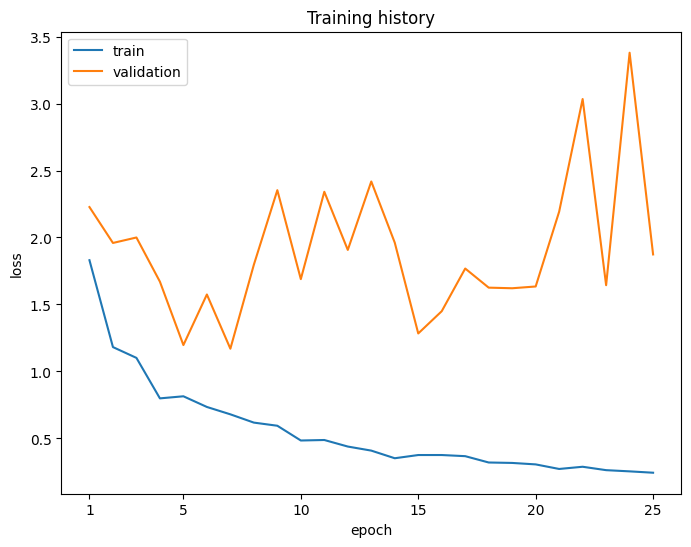

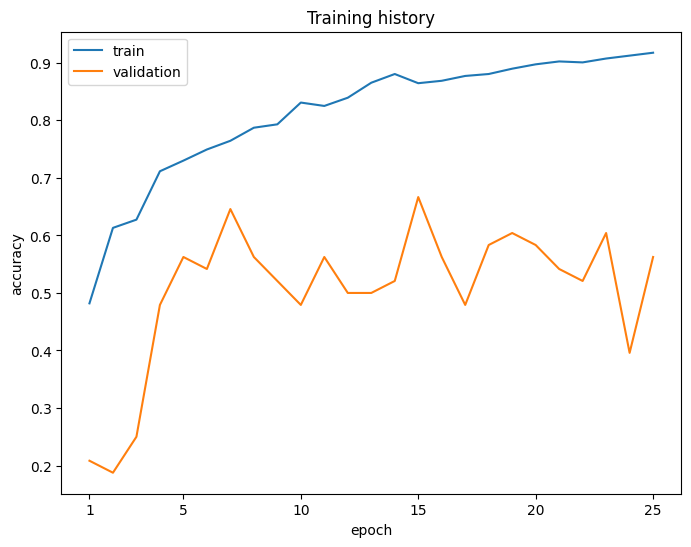

In [17]:
plot_history(history)

Load best model

In [18]:
model = keras.models.load_model("./models/dalle_variation_resnet_base/dalle_variation_resnet_base_15-0.6667.hdf5")
pred = model.predict(img_test, steps=len(img_test.filenames))

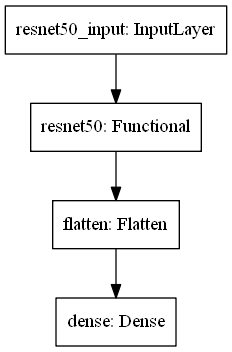

In [19]:
keras.utils.plot_model(model)

In [20]:
evaluate_classification_result(img_test.classes, pred,classes=["foggy","cloudy","sunny","snowy","rainy"])

[[2 2 0 3 3]
 [2 2 1 3 2]
 [5 1 1 1 2]
 [2 2 2 2 2]
 [4 1 1 2 2]]


Class foggy:
    Sensitivity (TPR):  20.000% (2 of 10)
    Specificity (TNR):  67.500% (27 of 40)
    Precision:          13.333% (2 of 15)
    Neg. pred. value:   77.143% (27 of 35)
Class cloudy:
    Sensitivity (TPR):  20.000% (2 of 10)
    Specificity (TNR):  85.000% (34 of 40)
    Precision:          25.000% (2 of 8)
    Neg. pred. value:   80.952% (34 of 42)
Class sunny:
    Sensitivity (TPR):  10.000% (1 of 10)
    Specificity (TNR):  90.000% (36 of 40)
    Precision:          20.000% (1 of 5)
    Neg. pred. value:   80.000% (36 of 45)
Class snowy:
    Sensitivity (TPR):  20.000% (2 of 10)
    Specificity (TNR):  77.500% (31 of 40)
    Precision:          18.182% (2 of 11)
    Neg. pred. value:   79.487% (31 of 39)
Class rainy:
    Sensitivity (TPR):  20.000% (2 of 10)
    Specificity (TNR):  77.500% (31 of 40)
    Precision:          18.182% (2 of 11)
    Neg. pred. value:   79.487% (31 of 39)

Overall accuracy:

array([[2, 2, 0, 3, 3],
       [2, 2, 1, 3, 2],
       [5, 1, 1, 1, 2],
       [2, 2, 2, 2, 2],
       [4, 1, 1, 2, 2]], dtype=int64)